# MNLI - Analysis Pipeline

**Task**: Natural Language Inference (NLI)  
**Objective**: Deep dive into model errors and behavior  

---

## Pipeline Overview

1. Environment Setup
2. Load Results
3. Error Pattern Analysis
4. Genre-wise Performance
5. Hypothesis/Premise Length Analysis
6. Cross-Model Agreement
7. Recommendations

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets
!pip install -q matplotlib seaborn pandas numpy wordcloud

In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

import torch
from datasets import load_from_disk, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [3]:
class AnalysisConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    EVAL_DIR = './evaluation'
    ANALYSIS_DIR = './analysis'
    
    MODELS = {
        'bert-base': 'mnli_bert-base_best',
        'distilbert': 'mnli_distilbert_best',
        'tinybert': 'mnli_tinybert_best'
    }

config = AnalysisConfig()
os.makedirs(config.ANALYSIS_DIR, exist_ok=True)

config_path = os.path.join(config.DATA_DIR, 'mnli_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

LABEL_NAMES = data_config['label_names']
NUM_LABELS = data_config['num_labels']

print(f"📋 Configuration loaded!")
print(f"   Labels: {LABEL_NAMES}")

📋 Configuration loaded!
   Labels: ['entailment', 'neutral', 'contradiction']


## 2. Load Results

In [4]:
report_path = os.path.join(config.EVAL_DIR, 'evaluation_report.json')
with open(report_path, 'r') as f:
    eval_report = json.load(f)

print("📊 Evaluation report loaded!")

📊 Evaluation report loaded!


In [5]:
print("📥 Loading MNLI dataset with text...")

original_dataset = load_dataset('glue', 'mnli')
test_matched_original = original_dataset['validation_matched']
test_mismatched_original = original_dataset['validation_mismatched']

print(f"✅ Original data loaded")

📥 Loading MNLI dataset with text...
✅ Original data loaded


In [6]:
dataset_path = os.path.join(config.DATA_DIR, 'mnli_tokenized')
tokenized_dataset = load_from_disk(dataset_path)

print(f"✅ Tokenized dataset loaded")

✅ Tokenized dataset loaded


In [7]:
def load_model(model_name):
    model_path = os.path.join(config.MODEL_DIR, config.MODELS[model_name])
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    return model, tokenizer

@torch.no_grad()
def get_predictions(model, dataset, batch_size=32):
    from torch.utils.data import DataLoader
    
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        
        if 'token_type_ids' in batch:
            token_type_ids = batch['token_type_ids'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(outputs.logits, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

print("📦 Loading models and predictions...")
results = {}

for model_name in config.MODELS.keys():
    try:
        print(f"   Loading {model_name}...")
        model, _ = load_model(model_name)
        
        preds_m, probs_m, labels_m = get_predictions(model, tokenized_dataset['test_matched'])
        preds_mm, probs_mm, labels_mm = get_predictions(model, tokenized_dataset['test_mismatched'])
        
        results[model_name] = {
            'matched': {'predictions': preds_m, 'probabilities': probs_m, 'labels': labels_m},
            'mismatched': {'predictions': preds_mm, 'probabilities': probs_mm, 'labels': labels_mm}
        }
        
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    except Exception as e:
        print(f"   ❌ Error loading {model_name}: {e}")

print(f"\n✅ Loaded predictions for {len(results)} models")

📦 Loading models and predictions...
   Loading bert-base...
   Loading distilbert...
   ❌ Error loading distilbert: DistilBertForSequenceClassification.forward() got an unexpected keyword argument 'token_type_ids'
   Loading tinybert...

✅ Loaded predictions for 2 models


## 3. Error Pattern Analysis

In [8]:
def analyze_errors(y_true, y_pred, label_names):
    """Analyze error patterns."""
    errors = []
    
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true != pred:
            errors.append({
                'index': i,
                'true_label': label_names[true],
                'pred_label': label_names[pred],
                'confusion': f"{label_names[true]} → {label_names[pred]}"
            })
    
    return pd.DataFrame(errors)

best_model = max(results.keys(), key=lambda m: accuracy_score(
    results[m]['matched']['labels'], results[m]['matched']['predictions']))

y_true = results[best_model]['matched']['labels']
y_pred = results[best_model]['matched']['predictions']

error_df = analyze_errors(y_true, y_pred, LABEL_NAMES)

print(f"📊 Error Analysis ({best_model} - Matched):")
print(f"   Total errors: {len(error_df)} / {len(y_true)} ({len(error_df)/len(y_true)*100:.1f}%)")

📊 Error Analysis (bert-base - Matched):
   Total errors: 2006 / 9815 (20.4%)


In [9]:
confusion_counts = error_df['confusion'].value_counts()

print("\n🔄 Most Common Confusions:")
print("="*50)
for pattern, count in confusion_counts.items():
    pct = count / len(error_df) * 100
    print(f"   {pattern}: {count} ({pct:.1f}%)")


🔄 Most Common Confusions:
   entailment → neutral: 479 (23.9%)
   neutral → contradiction: 440 (21.9%)
   contradiction → neutral: 393 (19.6%)
   neutral → entailment: 270 (13.5%)
   contradiction → entailment: 230 (11.5%)
   entailment → contradiction: 194 (9.7%)


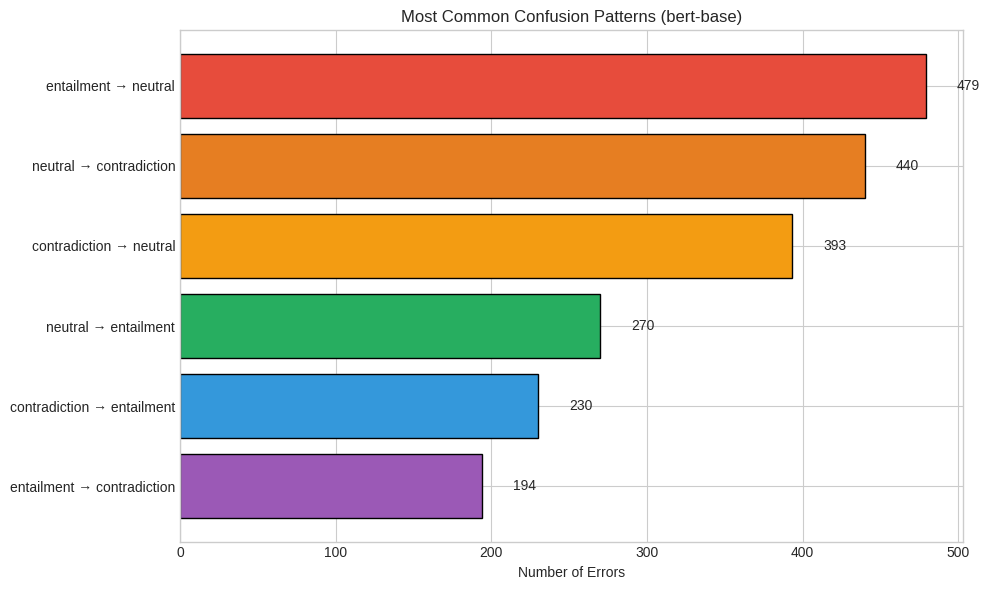

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

patterns = confusion_counts.head(6).index.tolist()
counts = confusion_counts.head(6).values

colors = ['#e74c3c', '#e67e22', '#f39c12', '#27ae60', '#3498db', '#9b59b6']
bars = ax.barh(patterns, counts, color=colors[:len(patterns)], edgecolor='black')

ax.set_xlabel('Number of Errors')
ax.set_title(f'Most Common Confusion Patterns ({best_model})')
ax.invert_yaxis()

for bar, count in zip(bars, counts):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
           f'{count}', va='center')

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'confusion_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Genre-wise Performance

In [12]:
def analyze_by_genre(predictions, labels, genres, label_names):
    """Compute per-genre accuracy."""
    genre_results = {}
    
    unique_genres = list(set(genres))
    
    for genre in unique_genres:
        mask = [g == genre for g in genres]
        genre_preds = predictions[mask]
        genre_labels = labels[mask]
        
        genre_results[genre] = {
            'accuracy': accuracy_score(genre_labels, genre_preds),
            'f1_macro': f1_score(genre_labels, genre_preds, average='macro'),
            'count': sum(mask)
        }
    
    return genre_results

try:
    if 'genre' in test_matched_original.column_names:
        genres_matched = test_matched_original['genre']
    else:
        print("Available columns:", test_matched_original.column_names)
        print("⚠️ Genre column not directly accessible, skipping genre-specific analysis")
        genres_matched = None
except Exception as e:
    print(f"⚠️ Could not access genre information: {e}")
    print("   Skipping genre-specific analysis")
    genres_matched = None

if genres_matched is not None:
    genre_results = analyze_by_genre(
        results[best_model]['matched']['predictions'],
        results[best_model]['matched']['labels'],
        genres_matched,
        LABEL_NAMES
    )

    print(f"\n📊 Per-Genre Performance ({best_model}):")
    print("="*60)

    genre_df = pd.DataFrame([
        {'Genre': g, 'Accuracy': r['accuracy'], 'F1 Macro': r['f1_macro'], 'Samples': r['count']}
        for g, r in sorted(genre_results.items(), key=lambda x: -x[1]['accuracy'])
    ])

    print(genre_df.round(4).to_string(index=False))
else:
    print("\n📊 Skipping per-genre analysis (genre information not available)")
    genre_results = None
    genre_df = None

Available columns: ['premise', 'hypothesis', 'label', 'idx']
⚠️ Genre column not directly accessible, skipping genre-specific analysis

📊 Skipping per-genre analysis (genre information not available)


In [13]:
if genre_df is not None:
    fig, ax = plt.subplots(figsize=(12, 6))

    genre_df_sorted = genre_df.sort_values('Accuracy', ascending=True)

    bars = ax.barh(genre_df_sorted['Genre'], genre_df_sorted['Accuracy'], 
                  color=plt.cm.RdYlGn(genre_df_sorted['Accuracy']), edgecolor='black')

    ax.set_xlabel('Accuracy')
    ax.set_title(f'Per-Genre Accuracy ({best_model})')
    ax.set_xlim(0, 1)

    for bar, acc in zip(bars, genre_df_sorted['Accuracy']):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
               f'{acc:.3f}', va='center')

    plt.tight_layout()
    plt.savefig(os.path.join(config.ANALYSIS_DIR, 'genre_performance.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⏭️ Skipping genre performance visualization")

⏭️ Skipping genre performance visualization


In [14]:
if genres_matched is not None and genre_results is not None:
    genre_comparison = []

    for model_name in results.keys():
        genre_res = analyze_by_genre(
            results[model_name]['matched']['predictions'],
            results[model_name]['matched']['labels'],
            genres_matched,
            LABEL_NAMES
        )
        
        for genre, metrics in genre_res.items():
            genre_comparison.append({
                'Model': model_name,
                'Genre': genre,
                'Accuracy': metrics['accuracy']
            })

    genre_comp_df = pd.DataFrame(genre_comparison)

    pivot = genre_comp_df.pivot(index='Genre', columns='Model', values='Accuracy')

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
               vmin=0.6, vmax=1.0, linewidths=0.5)
    ax.set_title('Model Accuracy by Genre')

    plt.tight_layout()
    plt.savefig(os.path.join(config.ANALYSIS_DIR, 'genre_model_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⏭️ Skipping genre model comparison")

⏭️ Skipping genre model comparison


## 5. Length Analysis

In [15]:
def analyze_by_length(predictions, labels, premises, hypotheses):
    """Analyze performance by text length."""
    premise_lens = [len(p.split()) for p in premises]
    hyp_lens = [len(h.split()) for h in hypotheses]
    combined_lens = [p + h for p, h in zip(premise_lens, hyp_lens)]
    
    results = []
    
    for i, (pred, true, p_len, h_len, c_len) in enumerate(zip(predictions, labels, premise_lens, hyp_lens, combined_lens)):
        results.append({
            'index': i,
            'correct': pred == true,
            'premise_len': p_len,
            'hypothesis_len': h_len,
            'combined_len': c_len,
            'true_label': LABEL_NAMES[true],
            'pred_label': LABEL_NAMES[pred]
        })
    
    return pd.DataFrame(results)

length_df = analyze_by_length(
    results[best_model]['matched']['predictions'],
    results[best_model]['matched']['labels'],
    test_matched_original['premise'],
    test_matched_original['hypothesis']
)

print(f"📏 Length Analysis ({best_model}):")
print(f"   Mean premise length: {length_df['premise_len'].mean():.1f} words")
print(f"   Mean hypothesis length: {length_df['hypothesis_len'].mean():.1f} words")

📏 Length Analysis (bert-base):
   Mean premise length: 19.3 words
   Mean hypothesis length: 9.9 words


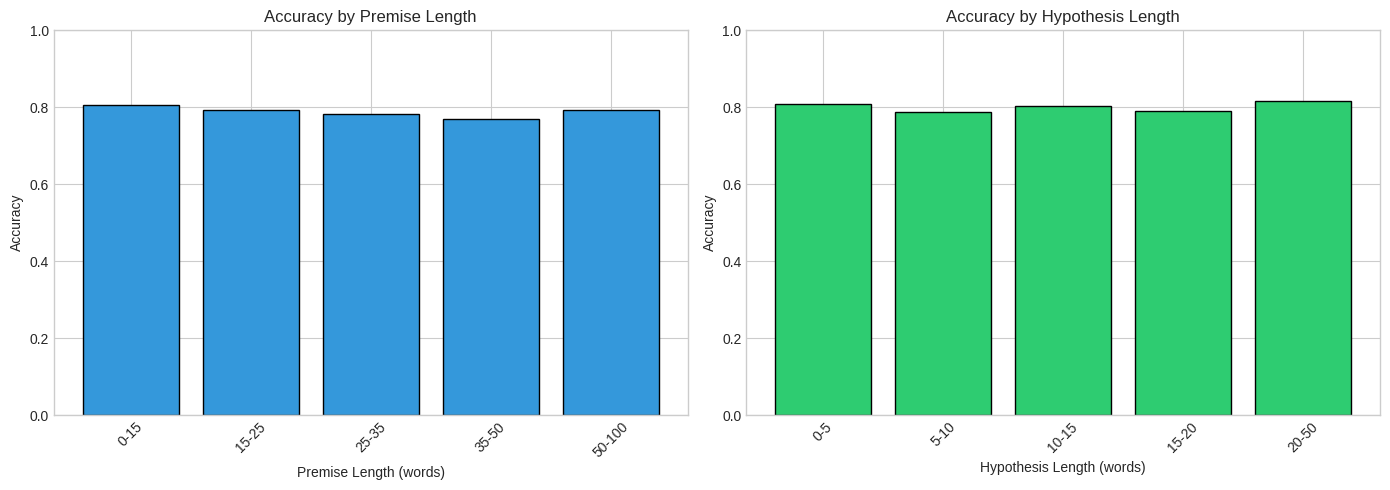

In [16]:
def bin_accuracy(df, length_col, bins):
    df['length_bin'] = pd.cut(df[length_col], bins=bins, labels=[f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)])
    return df.groupby('length_bin')['correct'].mean()

premise_bins = [0, 15, 25, 35, 50, 100]
premise_acc = bin_accuracy(length_df.copy(), 'premise_len', premise_bins)

hyp_bins = [0, 5, 10, 15, 20, 50]
hyp_acc = bin_accuracy(length_df.copy(), 'hypothesis_len', hyp_bins)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(premise_acc)), premise_acc.values, color='#3498db', edgecolor='black')
axes[0].set_xticks(range(len(premise_acc)))
axes[0].set_xticklabels(premise_acc.index, rotation=45)
axes[0].set_xlabel('Premise Length (words)')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Premise Length')
axes[0].set_ylim(0, 1)

axes[1].bar(range(len(hyp_acc)), hyp_acc.values, color='#2ecc71', edgecolor='black')
axes[1].set_xticks(range(len(hyp_acc)))
axes[1].set_xticklabels(hyp_acc.index, rotation=45)
axes[1].set_xlabel('Hypothesis Length (words)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy by Hypothesis Length')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'length_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Cross-Model Agreement

In [17]:
def analyze_agreement(results):
    """Analyze model agreement."""
    model_names = list(results.keys())
    n_samples = len(results[model_names[0]]['matched']['labels'])
    
    predictions = {name: results[name]['matched']['predictions'] for name in model_names}
    true_labels = results[model_names[0]]['matched']['labels']
    
    all_agree = np.ones(n_samples, dtype=bool)
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            all_agree &= (predictions[model_names[i]] == predictions[model_names[j]])
    
    all_correct = np.ones(n_samples, dtype=bool)
    for name in model_names:
        all_correct &= (predictions[name] == true_labels)
    
    return {
        'all_agree': all_agree,
        'all_correct': all_correct,
        'predictions': predictions,
        'true_labels': true_labels
    }

agreement = analyze_agreement(results)

n_total = len(agreement['all_agree'])
n_agree = agreement['all_agree'].sum()
n_all_correct = agreement['all_correct'].sum()

print("📊 Model Agreement Analysis:")
print(f"   Total samples: {n_total:,}")
print(f"   All models agree: {n_agree:,} ({n_agree/n_total*100:.1f}%)")
print(f"   All models correct: {n_all_correct:,} ({n_all_correct/n_total*100:.1f}%)")
print(f"   Disagreement: {n_total-n_agree:,} ({(n_total-n_agree)/n_total*100:.1f}%)")

📊 Model Agreement Analysis:
   Total samples: 9,815
   All models agree: 8,188 (83.4%)
   All models correct: 7,025 (71.6%)
   Disagreement: 1,627 (16.6%)


In [18]:
disagree_mask = ~agreement['all_agree']
disagree_indices = np.where(disagree_mask)[0]

unique_correct = {name: 0 for name in results.keys()}

for idx in disagree_indices:
    true_label = agreement['true_labels'][idx]
    correct_models = [name for name, preds in agreement['predictions'].items() if preds[idx] == true_label]
    
    if len(correct_models) == 1:
        unique_correct[correct_models[0]] += 1

print("\n🏆 Uniquely Correct on Disagreements:")
for name, count in sorted(unique_correct.items(), key=lambda x: -x[1]):
    print(f"   {name}: {count} samples")


🏆 Uniquely Correct on Disagreements:
   bert-base: 784 samples
   tinybert: 663 samples


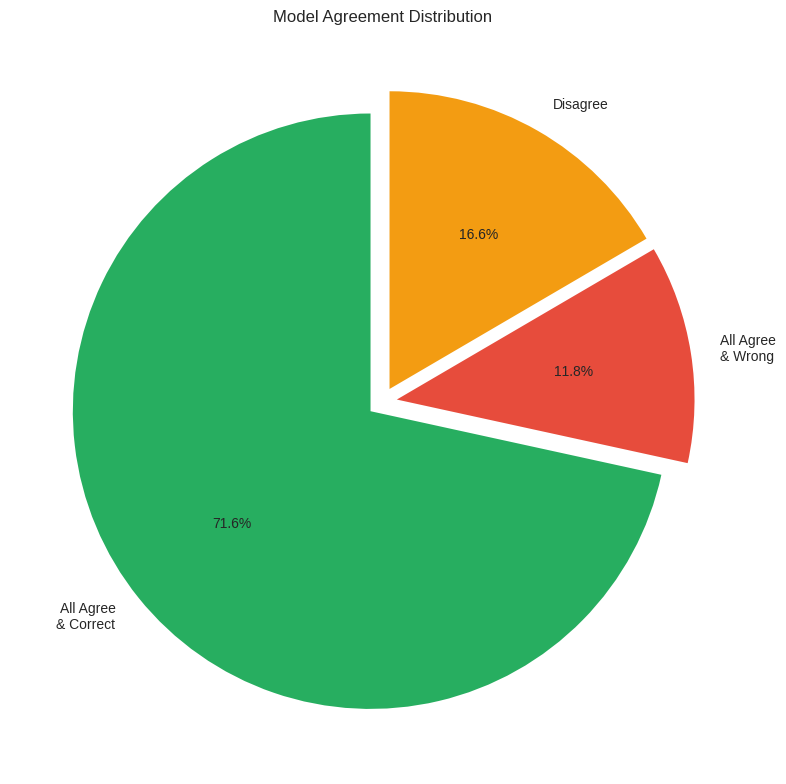

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

agree_correct = (agreement['all_agree'] & agreement['all_correct']).sum()
agree_wrong = (agreement['all_agree'] & ~agreement['all_correct']).sum()
disagree = (~agreement['all_agree']).sum()

labels = ['All Agree\n& Correct', 'All Agree\n& Wrong', 'Disagree']
sizes = [agree_correct, agree_wrong, disagree]
colors = ['#27ae60', '#e74c3c', '#f39c12']

wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, colors=colors, autopct='%1.1f%%',
    startangle=90, explode=(0.05, 0.05, 0.05)
)

ax.set_title('Model Agreement Distribution')

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'model_agreement.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Hard Examples Analysis

In [20]:
all_wrong = np.ones(len(agreement['true_labels']), dtype=bool)
for name, preds in agreement['predictions'].items():
    all_wrong &= (preds != agreement['true_labels'])

all_wrong_indices = np.where(all_wrong)[0]

print(f"📊 Hard Samples (all models wrong): {len(all_wrong_indices)} samples")
print("\n🔍 Sample Hard Examples:")
print("="*80)

for i, idx in enumerate(all_wrong_indices[:5]):
    premise = test_matched_original[int(idx)]['premise']
    hypothesis = test_matched_original[int(idx)]['hypothesis']
    true_label = LABEL_NAMES[agreement['true_labels'][idx]]
    
    print(f"\n[Example {i+1}]")
    print(f"   Premise: {premise[:100]}...")
    print(f"   Hypothesis: {hypothesis}")
    print(f"   True: {true_label}")
    print(f"   Predictions:")
    for name, preds in agreement['predictions'].items():
        print(f"      {name}: {LABEL_NAMES[preds[idx]]}")

📊 Hard Samples (all models wrong): 1343 samples

🔍 Sample Hard Examples:

[Example 1]
   Premise: um-hum um-hum yeah well uh i can see you know it's it's it's it's kind of funny because we it seems ...
   Hypothesis: We don't loan a lot of money.
   True: neutral
   Predictions:
      bert-base: contradiction
      tinybert: contradiction

[Example 2]
   Premise: oh uh-huh well no they wouldn't would they no...
   Hypothesis: No, they wouldn't go there.
   True: neutral
   Predictions:
      bert-base: entailment
      tinybert: entailment

[Example 3]
   Premise: i'm not opposed to it but when its when the time is right it will probably just kind of happen you k...
   Hypothesis: I cannot wait for it to happen.
   True: neutral
   Predictions:
      bert-base: contradiction
      tinybert: entailment

[Example 4]
   Premise: Table 2: Examples of BLM's, FHWA's, IRS's, and VBA's Customer Satisfaction Expectations for Senior E...
   Hypothesis: Senior Executive's have been studies on var

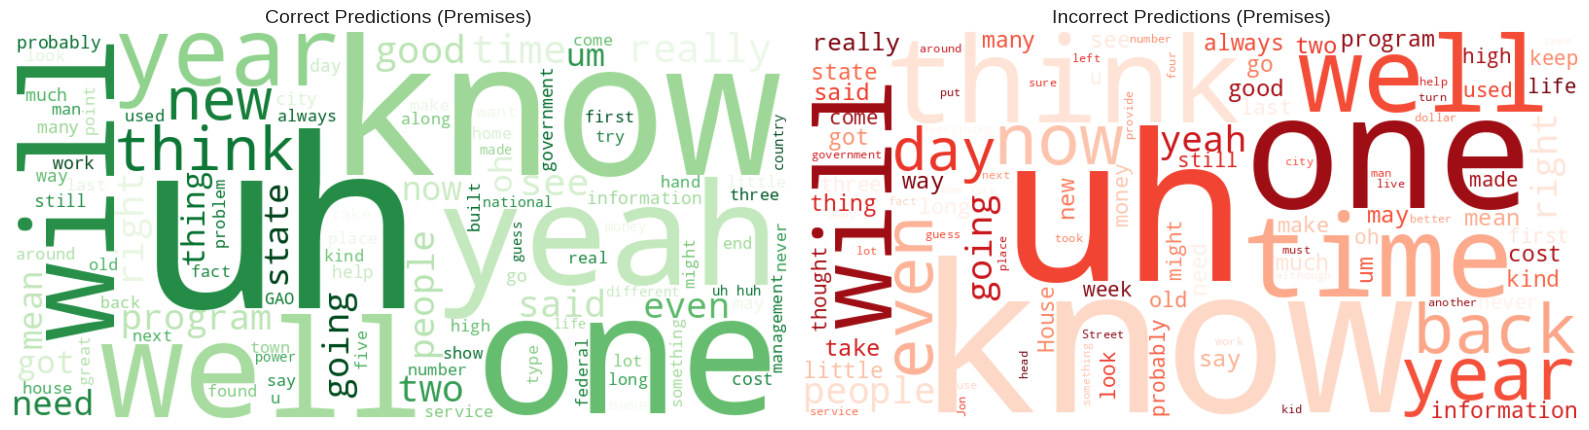

In [22]:
correct_mask = results[best_model]['matched']['predictions'] == results[best_model]['matched']['labels']

correct_indices = [int(i) for i in np.where(correct_mask)[0][:2000]]
incorrect_indices = [int(i) for i in np.where(~correct_mask)[0][:2000]]

correct_premises = ' '.join([test_matched_original[i]['premise'] for i in correct_indices])
incorrect_premises = ' '.join([test_matched_original[i]['premise'] for i in incorrect_indices])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if correct_premises:
    wc_correct = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(correct_premises)
    axes[0].imshow(wc_correct, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('Correct Predictions (Premises)', fontsize=14)

if incorrect_premises:
    wc_incorrect = WordCloud(width=800, height=400, background_color='white',
                            colormap='Reds', max_words=100).generate(incorrect_premises)
    axes[1].imshow(wc_incorrect, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Incorrect Predictions (Premises)', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'wordclouds.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Recommendations

In [23]:
print("\n" + "="*80)
print("📋 ANALYSIS RECOMMENDATIONS")
print("="*80)

print("\n🏆 1. MODEL SELECTION")
best_acc = 0
best_model_name = ''
for name in results.keys():
    acc = accuracy_score(results[name]['matched']['labels'], results[name]['matched']['predictions'])
    if acc > best_acc:
        best_acc = acc
        best_model_name = name
print(f"   • Best model: {best_model_name} (Accuracy: {best_acc:.4f})")

print("\n⚠️ 2. COMMON CONFUSIONS")
top_confusions = confusion_counts.head(3)
for pattern, count in top_confusions.items():
    print(f"   • {pattern}: {count} errors")
print("   • Recommendation: Focus on neutral/entailment disambiguation")

print("\n📚 3. GENRE INSIGHTS")
if genre_df is not None and len(genre_df) > 0:
    worst_genre = genre_df.nsmallest(min(2, len(genre_df)), 'Accuracy')
    print(f"   • Challenging genres: {worst_genre['Genre'].tolist()}")
    print("   • Consider: Genre-specific fine-tuning or data augmentation")
else:
    print("   • Genre information not available in dataset")
    print("   • Consider: Performance may vary across text domains")

print("\n📏 4. LENGTH CONSIDERATIONS")
print("   • Longer premises may benefit from increased max_length")
print("   • Short hypotheses can be ambiguous")

print("\n🔗 5. ENSEMBLE POTENTIAL")
print(f"   • Models disagree on {(~agreement['all_agree']).sum()} samples")
print(f"   • Ensemble voting could improve robustness")

print("\n" + "="*80)


📋 ANALYSIS RECOMMENDATIONS

🏆 1. MODEL SELECTION
   • Best model: bert-base (Accuracy: 0.7956)

⚠️ 2. COMMON CONFUSIONS
   • entailment → neutral: 479 errors
   • neutral → contradiction: 440 errors
   • contradiction → neutral: 393 errors
   • Recommendation: Focus on neutral/entailment disambiguation

📚 3. GENRE INSIGHTS
   • Genre information not available in dataset
   • Consider: Performance may vary across text domains

📏 4. LENGTH CONSIDERATIONS
   • Longer premises may benefit from increased max_length
   • Short hypotheses can be ambiguous

🔗 5. ENSEMBLE POTENTIAL
   • Models disagree on 1627 samples
   • Ensemble voting could improve robustness



In [24]:
analysis_report = {
    'dataset': 'MNLI',
    'task': 'Natural Language Inference',
    'error_analysis': {
        'total_errors': len(error_df),
        'top_confusions': dict(confusion_counts.head(5))
    },
    'genre_analysis': genre_df.to_dict('records') if genre_df is not None else None,
    'model_agreement': {
        'all_agree_pct': float(n_agree / n_total * 100),
        'all_correct_pct': float(n_all_correct / n_total * 100),
        'disagreement_samples': int(n_total - n_agree)
    },
    'hard_samples': len(all_wrong_indices),
    'recommendations': {
        'best_model': best_model_name,
        'challenging_genres': worst_genre['Genre'].tolist() if genre_df is not None and len(genre_df) > 0 else [],
        'main_confusion': list(top_confusions.head(1).index)[0] if len(top_confusions) > 0 else None
    }
}

report_path = os.path.join(config.ANALYSIS_DIR, 'analysis_report.json')
with open(report_path, 'w') as f:
    json.dump(analysis_report, f, indent=2, default=str)

print(f"\n✅ Analysis report saved to: {report_path}")


✅ Analysis report saved to: ./analysis/analysis_report.json
